In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from pickle import dump


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [24]:
df_customer_data = pd.read_csv("Momos Data Case Study - Data Set.csv")

In [25]:
df_customer_data['year_month'] = pd.to_datetime(df_customer_data['transaction_date']).dt.to_period('M')

In [129]:
df_customer_data["is_weekend"] = pd.to_datetime(df_customer_data.transaction_date).dt.dayofweek > 4

In [136]:
df_customer_data["is_weekend"] = df_customer_data["is_weekend"].astype(int)

## Average monthly promo and ad spend per brand and channel

In [34]:
# df_ad_promo_spend =
df_customer_data.groupby(['year_month','brand_name','channel']).agg({'ad_spend':'sum','platform_promo_spend':'sum'}).reset_index().replace(0, np.nan)\
                .groupby(['brand_name','channel']).agg({'ad_spend':'mean','platform_promo_spend':'mean'}).reset_index()

,brand_name,channel,ad_spend,platform_promo_spend
0,Club Street,Platform C,NaN,575.992000
1,Louvré,Facebook,210.796667,NaN
2,Pizzeria,Facebook,1263.928333,NaN
3,Pizzeria,Platform A,NaN,43.330000
4,Pizzeria,Platform B,NaN,212.934545
5,Pizzeria,Platform C,45.110000,2918.763333
6,The Beach,Facebook,219.780909,NaN
7,The Brunch Place,Facebook,631.639167,NaN
8,The Brunch Place,Platform C,NaN,22.470000


# Data Preparation For Dashboard and Feature Generation

Looking at the schema information shared, it is clear that every record represents a separate ad. Using this we can get the number of ads run per day

In [4]:
df_ads_grouped_per_day = df_customer_data.loc[df_customer_data["channel"]=='Facebook',].groupby(['transaction_date','year_month','brand_name','outlet_name']).\
                                        agg({'channel':'count',
                                             'ad_spend':'sum',
                                             'clicks':'sum',
                                             'impressions':'sum',
                                             'reach':'sum'
                                            }).reset_index().rename(columns={'channel':'no_of_ads'})


In [336]:
df_ads_grouped_per_day.to_csv('Data files for Dashboard/Ads_grouped_per_day.csv', index = False)

In [137]:
df_ads_grouped_per_day['cost_per_click'] = df_ads_grouped_per_day['ad_spend']/df_ads_grouped_per_day['clicks']

## Mapping the transaction hours to time of day for easy interpretation and for feature generation

In [327]:
df_platforms = df_customer_data.loc[df_customer_data["channel"] !='Facebook',df_customer_data.columns.difference(['ad_spend','clicks','impressions','reach'])]

In [130]:
df_platform_grouped_per_day = df_customer_data.loc[df_customer_data["channel"] !='Facebook',df_customer_data.columns.difference(['ad_spend','clicks','impressions','reach'])].\
               groupby(['transaction_date','brand_name','outlet_name','year_month','is_weekend']).\
               agg({ 
                    'total_orders' : 'sum',
                    'total_completed_orders' : 'sum',
                    'total_sales' : 'sum',
                    'total_promo_orders' :'sum',
                    'total_promo_sales' : 'sum',
                    'total_non_promo_orders' :'sum',
                    'total_non_promo_sales' : 'sum',
                    'platform_promo_spend' : 'sum'
                   }).reset_index()


In [330]:
bins=[0, 5, 12,18,22,24]
labels=['4.Late night', '1.Morning', '2.Afternoon','3.Evening','4.Late night']
df_platforms["time_of_day"] = pd.cut(df_customer_data['transaction_hour'], bins, labels=labels,ordered=False)


In [329]:
df_platforms.columns

Index(['brand_name', 'channel', 'is_weekend', 'order_type', 'outlet_name',
       'platform_promo_spend', 'total_completed_orders',
       'total_non_promo_orders', 'total_non_promo_sales', 'total_orders',
       'total_promo_orders', 'total_promo_sales', 'total_sales',
       'transaction_date', 'transaction_hour', 'year_month'],
      dtype='object')


## Analysing the impact of Promotions by channel and time of day

In [331]:
df_platforms.groupby(['brand_name','channel', 'time_of_day','order_type','is_weekend']).agg({'total_promo_orders':'sum','total_promo_sales':'sum','total_non_promo_orders':'sum','total_non_promo_sales':'sum'}).reset_index()\
.to_csv("Data files for Dashboard/platform_promo_impact_1.1.csv", index=False)

The data is tabulated using Data studio on Page 'Monthly Promo and Ad Spend'

### Creating Pivots on Time of day and platform for promo spend to create features

In [132]:
df_time_of_day_promo_pivot = df_platforms.pivot_table(['platform_promo_spend'], ['brand_name','outlet_name','transaction_date','year_month'], 'time_of_day')
df_time_of_day_promo_pivot.columns = [b+'_promo_spend' for a, b in df_time_of_day_promo_pivot.columns]
df_time_of_day_promo_pivot = df_time_of_day_promo_pivot.reset_index()

In [133]:
df_platform_pivot = df_platforms.pivot_table(['platform_promo_spend'], ['brand_name','outlet_name','transaction_date','year_month'], 'channel')
df_platform_pivot.columns = [b+'_spend' for a, b in df_platform_pivot.columns]
df_platform_pivot = df_platform_pivot.reset_index()

In [134]:
df_platform_grouped_per_day = df_platform_grouped_per_day.merge(df_time_of_day_promo_pivot, how ='left', left_on =['transaction_date','brand_name','outlet_name','year_month'],\
                 right_on =['transaction_date','brand_name','outlet_name','year_month'])\
           .merge(df_platform_pivot, how ='left', left_on =['transaction_date','brand_name','outlet_name','year_month'],\
                 right_on =['transaction_date','brand_name','outlet_name','year_month'])

In [139]:
del df_time_of_day_promo_pivot
del df_platform_pivot

In [140]:
df_final = df_platform_grouped_per_day.merge(df_ads_grouped_per_day, how ='outer', left_on =['transaction_date','brand_name','outlet_name','year_month'],\
                 right_on =['transaction_date','brand_name','outlet_name','year_month'])

In [332]:
df_final.to_csv("Data files for Dashboard/Final_dashboard.csv", index=False)

# Linear Regression

The objective is to predict the customer sales and for the customer to decide if they should run a promo or ad or none. 
With the given dataset, most of the variables are associated with sales and orders (which are in a way the target variable). <br>
The variables in the dataset which are in the control of customer that can affect the sales are ad_spend, promo_spend, number of ads and the platform on which they run the promo, etc.
So I decided to predict the total sales for the customer, <br>given their spend on ad, promo and platform. This will let the customer to try all the possible business scenario and use the projected revenue to come up with the best approach.

Given this information, I think it is better to try linear regerssion model for the following reasons :
    - The dependent varriable is a continuous variable and linear regression is one of the best algorithms to predict continuous variable
    - We could try regression tree algorithms. But given that the dataset is very small, there is a high chance that we will overfit the data
    - Linear regression lets us evaluate the coefficients easily and this can be easily translated into insights which can be easily understood by stakeholders
    
Future Improvements :
    - With this dataset, I have assumed that all brands and outlets are similar to each other, which is not the case in real life. 
    - The first improvement will be to add features related to outlets and brands like capacity, cuisine, operating_hours.
    - The other set of data that will be helpful is to get more information about the promos and ad., like voucher value, offer_type.
    - I had planned to add outlet level features like average orders per day, average order value, but couldn't add them due to lack of time.
    - The other approach that we can do is to have ensemble of algorithms that could be used to recommend the split of investment into ads,
        promo (including platform) given the target sales, available investment .
    
    

#### There are some records in the dataset which are only for ad spend with no promotions. Since our objective is to estimate sales, removing these records from the dataset

####  The required feature variables are selected based on the correlation score to remove highly correalated variables.

In [304]:
selected_columns  = ['total_sales','is_weekend','no_of_ads','ad_spend','cost_per_click','1.Morning_promo_spend', '2.Afternoon_promo_spend',
       '3.Evening_promo_spend', '4.Late night_promo_spend', 'Platform A_spend',
       'Platform B_spend', 'Platform C_spend','platform_promo_spend']



In [305]:
df_model_data = df_final.loc[(~df_final['total_sales'].isna())  & ( df_final['total_sales']>0 ),][selected_columns]

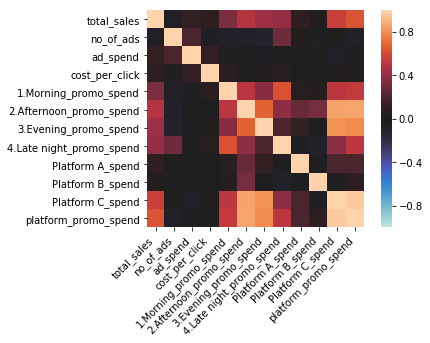

In [307]:
corr = df_model_data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [308]:
selected_column_subset = ['total_sales','is_weekend','no_of_ads','cost_per_click', 'Platform A_spend',
       'Platform B_spend', 'Platform C_spend','ad_spend']#,'spend_per_ad']

In [309]:
df_model_data = df_model_data[selected_column_subset]

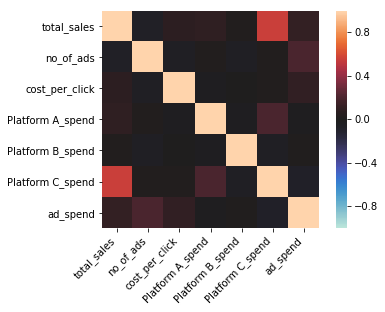

In [310]:
corr = df_model_data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [278]:
# df_model_data['spend_per_ad'] = df_model_data['ad_spend']/df_model_data['no_of_ads']

In [279]:
df_model_data.isnull().values.any()

True

In [280]:
df_model_data.describe()

,total_sales,no_of_ads,cost_per_click,Platform A_spend,Platform B_spend,Platform C_spend,ad_spend
count,931.000000,362.000000,362.000000,359.000000,246.000000,745.000000,362.000000
mean,632.082019,5.494475,0.534530,0.027255,3.742396,4.012574,41.563398
std,597.508487,1.941306,0.136280,0.240362,6.478397,9.144897,15.603565
min,12.840000,3.000000,0.197558,0.000000,0.000000,0.000000,14.410000
25%,216.125000,4.000000,0.451252,0.000000,0.000000,0.000000,32.900000
50%,427.980000,5.000000,0.522513,0.000000,2.176667,0.000000,36.000000
75%,884.875000,6.000000,0.614376,0.000000,5.399000,4.200000,46.372500
max,3848.880000,13.000000,1.139643,3.027500,80.400000,82.390000,121.490000


In [281]:
df_model_data = df_model_data.fillna(0)

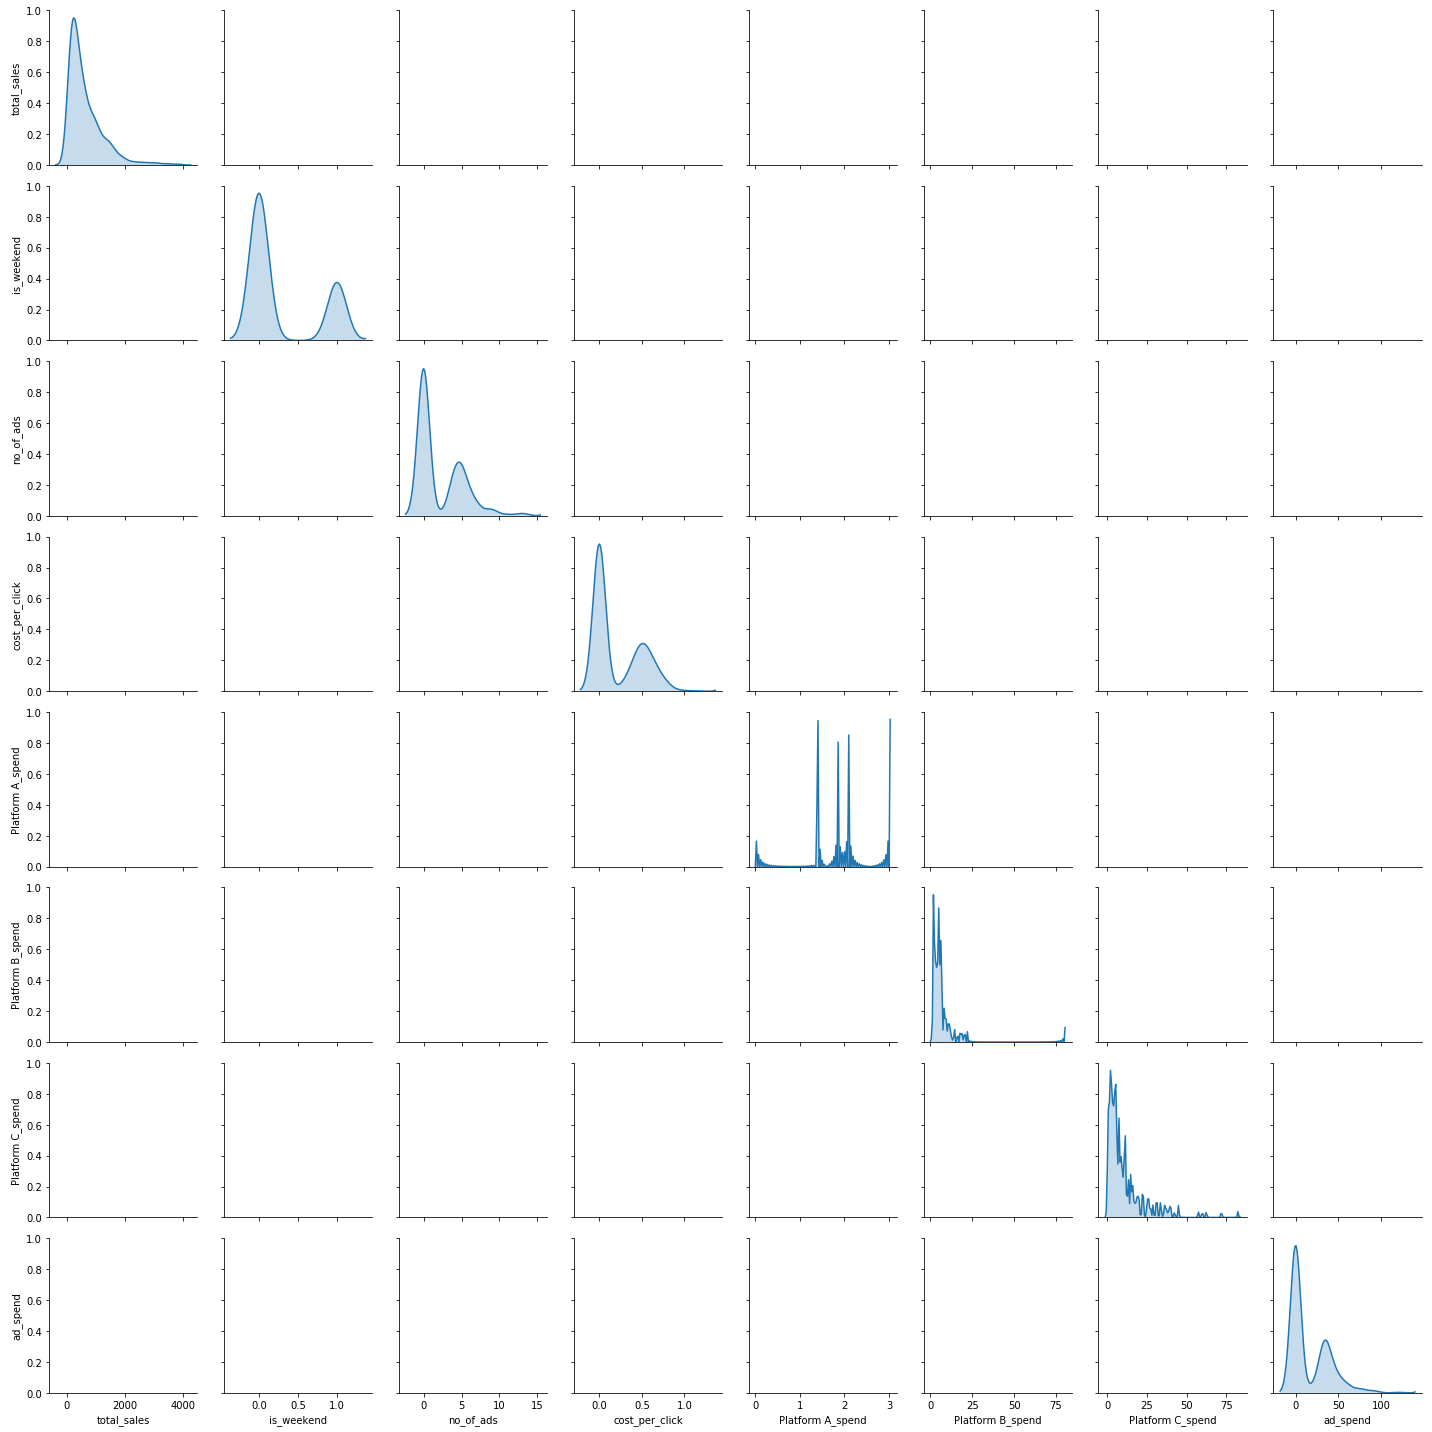

In [282]:
_ = sns.pairplot(df_model_data, kind="auto", diag_kind="kde")


 #### Looking at the plots above, it is clear that we need to standardize the variables to reduce multicollinearity and  to improve the performance of the model

In [287]:
X = df_model_data.drop(["total_sales"], axis=1)
y = df_model_data['total_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [289]:
X_test.shape

(187, 7)

In [290]:
scaler = StandardScaler()

In [291]:
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)


In [292]:
model = LinearRegression()

In [293]:
model.fit(train_scaled, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [294]:
mse = mean_squared_error(y_train, model.predict(train_scaled))
mae = mean_absolute_error(y_train, model.predict(train_scaled))


In [295]:
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))


mse =  220628.4210340036  & mae =  341.7018722360875  & rmse =  469.7109973526313


In [296]:
test_mse = mean_squared_error(y_test, model.predict(test_scaled))
test_mae = mean_absolute_error(y_test, model.predict(test_scaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))


mse =  236221.30040076788  & mae =  348.160919344418  & rmse =  486.02602852189705


Text(0.5, 0, 'Truths')

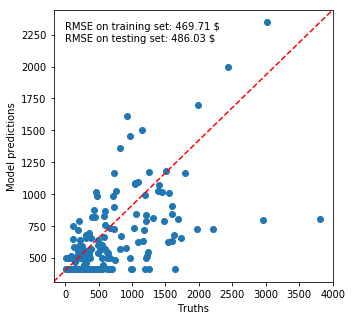

In [315]:
y_pred = model.predict(test_scaled)
string_score = f"RMSE on training set: {sqrt(mse):.2f} $"
string_score += f"\nRMSE on testing set: {sqrt(test_mse):.2f} $"
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_pred)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3,2200, string_score)
plt.ylabel("Model predictions")
plt.xlabel("Truths")
# plt.xlim([0, 27])
# _ = plt.ylim([0, 27])

### MODEL RESULTS:

#### - As we can see from the Root Mean Squared Values  (\\$470 for training set and \\$486 for the test set), the model performance is not ideal (predictions are off by \\$486) 
#### - But taking a look at the scatter plot shows that quite a few predictions are far off and the RMSE is skewed because few predictions ( as the test set is small). This can be validated with a bigger dataset


### MODEL COEFFICIENT INTERPRETATION:


In [316]:
pd.DataFrame(model.coef_/scaler.scale_ * scaler.scale_[0], 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)


,coef
is_weekend,41.808892
Platform C_spend,17.167259
Platform B_spend,4.710557
ad_spend,2.585366
no_of_ads,-4.998096
cost_per_click,-6.461223
Platform A_spend,-63.448940


## These are some of the insights that should be shared with the customers. Given all the other variables are constant, the following individual points are valid. The important note here is that the coefficients represent association and not causation

#### - An outlet has \\$41 more sales per day during weekend compared to weekday
#### - \\$1 promo spend on Platform C is associated with an increase of \\$17 in total sales
#### - \\$1 promo spend on Platform B is associated with an increase of \\$4 in total sales
#### - \\$1 promo spend on Platform A is associated with an decrease of \\$63 in total sales
#### - Point to note here is the current dataset is heavily skewed towards with 90\% of total promo spend on this platform in 2020. So we should be careful while making decision based on these.
#### - \\$1 spend in ad is associated with an increase of $2.6 in sales
#### - Given these information, it is fair to say that it is beneficical for customer to allocate more budget to promo compared to ads as it will return higher returns
#### - Seeing that the no_of_ads is negatively correlated with spend, customers should put in effort to optimize the number of as they run
#### - \\$1 improvement (reduction) in Cost per click for ads is associated with \\$6 improvement in total sales





## PICKLING THE MODEL FOR SERVING ON CUSTOMERS

- I have built a sample web application which will be able to serve the prediction results for a given customer input
- The same can be exposed as an API and can be integrated into the momos platform


In [334]:
# save the model
dump(model, open('Models/model.pkl', 'wb'))


In [335]:
# save the scaler
dump(scaler, open('Models/scaler.pkl', 'wb'))